In [33]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

# Functions for computing primal gaps and CPI

def primal_gap(f_opt, f_curr):
    if f_opt == 0 and f_curr == 0:
        return 0
    elif f_opt * f_curr < 0:
        return 1
    else:
        return abs(f_opt - f_curr) / max(abs(f_opt), abs(f_curr))

def compute_primal_gaps(f_opt, objectives):
    return [primal_gap(f_opt, f) for f in objectives]

def compute_primal_gap_function(t_max, times, primal_gaps):
    primal_gap_function = [(0, 1)]  # Start with a gap of 1 at time 0
    for t, gap in zip(times, primal_gaps):
        primal_gap_function.append((t, gap))
    primal_gap_function.append((t_max, primal_gap_function[-1][1]))  # Extend to t_max
    return primal_gap_function

def compute_confined_primal_gap_function(primal_gap_function, alpha):
    return [(t, gap * np.exp(t / alpha)) for t, gap in primal_gap_function]

def compute_cpi(primal_gap_function, confined_primal_gap_function, alpha):
    cpi = 0
    for i in range(1, len(primal_gap_function)):
        t_prev, gap_prev = confined_primal_gap_function[i-1]
        t_curr, gap_curr = confined_primal_gap_function[i]
        cpi += gap_prev * (np.exp(t_curr / alpha) - np.exp(t_prev / alpha))
    return alpha * cpi

# Function to parse time-objective pairs
def parse_pairs(pairs_str):
    return [(float(time), float(obj)) for time, obj in re.findall(r'\(([^ ]+) ([^ ]+)\)', pairs_str)]

# Load data
data = pd.read_csv('../results/random-d4-gurobi-hot.csv')

# Initialize lists to store CPI values
ilp_cpis = []
alns_median_cpis = []

ilp_ttss = []
alns_ttss = []

# Process each row in the DataFrame
for idx, row in data.iterrows():
    ilp_pairs = parse_pairs(row['ilp-incumbent'])
    alns_pairs = [parse_pairs(row[f'alns-{i}']) for i in range(1,6)]

    # calculate the average time to solution
    ilp_tts = ilp_pairs[-1][1]
    temp = sorted(alns_pairs, key=lambda pairs: pairs[-1][1])
    idx = len(alns_pairs) // 2
    alns_tts_median = temp[idx][-1][1]
    ilp_ttss.append(ilp_tts)
    alns_ttss.append(alns_tts_median)

    # Combine all pairs to find the best solution for normalization
    all_pairs = ilp_pairs + [pair for pairs in alns_pairs for pair in pairs]
    best_solution = min(pair[0] for pair in all_pairs)

    # Define the maximum time and importance
    t_max = max(pair[1] for pair in all_pairs)
    importance = 0.5
    alpha = t_max / np.log(importance)

    # Compute CPI for ILP
    ilp_times = [t for _, t in ilp_pairs]
    ilp_objectives = [obj for obj, _ in ilp_pairs]
    ilp_primal_gaps = compute_primal_gaps(best_solution, ilp_objectives)
    ilp_primal_gap_function = compute_primal_gap_function(t_max, ilp_times, ilp_primal_gaps)
    ilp_confined_primal_gap_function = compute_confined_primal_gap_function(ilp_primal_gap_function, alpha)
    ilp_cpi = compute_cpi(ilp_primal_gap_function, ilp_confined_primal_gap_function, alpha)
    ilp_cpis.append(ilp_cpi)

    # Compute CPI for each ALNS pair and find the third lowest CPI value
    alns_cpis = []
    for pairs in alns_pairs:
        alns_times = [t for _, t in pairs]
        alns_objectives = [obj for obj, _ in pairs]
        alns_primal_gaps = compute_primal_gaps(best_solution, alns_objectives)
        alns_primal_gap_function = compute_primal_gap_function(t_max, alns_times, alns_primal_gaps)
        alns_confined_primal_gap_function = compute_confined_primal_gap_function(alns_primal_gap_function, alpha)
        alns_cpi = compute_cpi(alns_primal_gap_function, alns_confined_primal_gap_function, alpha)
        alns_cpis.append(alns_cpi)

    alns_cpis.sort()
    idx = len(alns_cpis) // 2
    alns_median_cpi = alns_cpis[idx]  # Get the median CPI
    alns_median_cpis.append(alns_median_cpi)


# Create a new DataFrame to store the results
results_df = pd.DataFrame({
    'cycles': data['cycles'],
    'ILP_CPI': ilp_cpis,
    'ALNS_median_CPI': alns_median_cpis,
    'ILP_tts': ilp_ttss,
    'ALNS_tts': alns_ttss
})

#CHANGE THIS
# filtered_df = results_df[results_df['cycles'] < 300000]
filtered_df = results_df

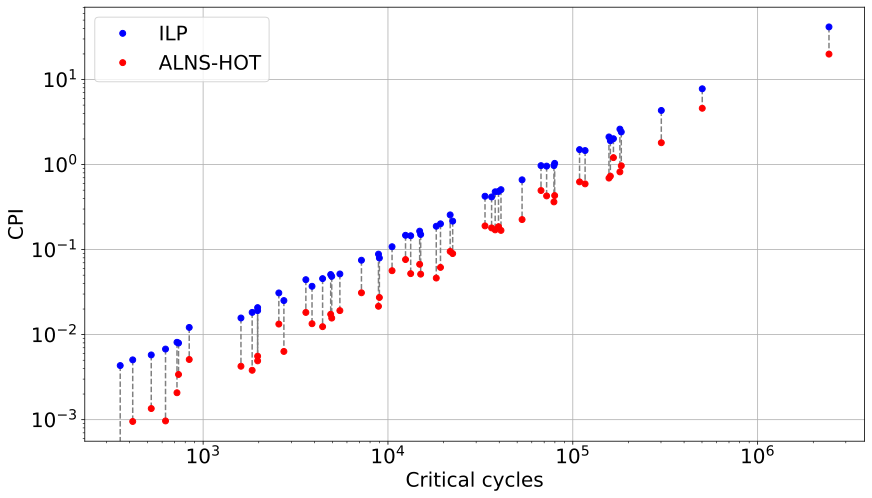

In [34]:
import matplotlib.pyplot as plt

# Ensure index is reset after filtering to avoid KeyError
filtered_df.reset_index(drop=True, inplace=True)

# Plot setup
plt.figure(figsize=(14, 8))

# Draw lines between ILP and ALNS points for each cycle
for i in range(len(filtered_df)):
    plt.plot([filtered_df['cycles'][i], filtered_df['cycles'][i]], 
             [filtered_df['ILP_CPI'][i], filtered_df['ALNS_median_CPI'][i]], 
             color='gray', linestyle='--')
    
# Plot ILP CPI values
plt.plot(filtered_df['cycles'], filtered_df['ILP_CPI'], color='blue', marker='o', linestyle='none', label='ILP')

# Plot ALNS 3rd Lowest CPI values
plt.plot(filtered_df['cycles'], filtered_df['ALNS_median_CPI'], color='red', marker='o', linestyle='none', label='ALNS-HOT')

plt.xscale('log')
plt.yscale('log')
# Final plot adjustments
plt.xlabel('Critical cycles')
plt.ylabel('CPI')
plt.legend()
plt.grid(True)
plt.rcParams.update({'font.size': 20})
plt.show()


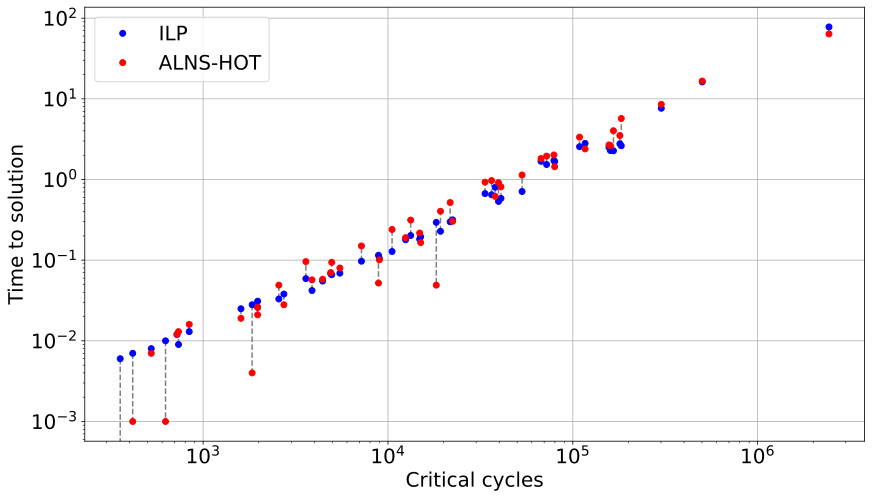

In [35]:
import matplotlib.pyplot as plt

# Ensure index is reset after filtering to avoid KeyError
filtered_df.reset_index(drop=True, inplace=True)

# Plot setup
plt.figure(figsize=(14, 8))

# Draw lines between ILP and ALNS points for each cycle
for i in range(len(filtered_df)):
    plt.plot([filtered_df['cycles'][i], filtered_df['cycles'][i]], 
             [filtered_df['ILP_tts'][i], filtered_df['ALNS_tts'][i]], 
             color='gray', linestyle='--')
    
# Plot ILP CPI values
plt.plot(filtered_df['cycles'], filtered_df['ILP_tts'], color='blue', marker='o', linestyle='none', label='ILP')

# Plot ALNS 3rd Lowest CPI values
plt.plot(filtered_df['cycles'], filtered_df['ALNS_tts'], color='red', marker='o', linestyle='none', label='ALNS-HOT')

plt.xscale('log')
plt.yscale('log')
# Final plot adjustments
plt.xlabel('Critical cycles')
plt.ylabel('Time to solution')
plt.legend()
plt.grid(True)
plt.rcParams.update({'font.size': 20})
plt.show()

In [18]:
ilp_pairs = parse_pairs(data['ilp-incumbent'][30])
alns_pairs = [parse_pairs(data[f'alns-{i}'][30]) for i in range(1, 4)]
print(alns_pairs)

[[(18.0, 0.094), (17.0, 0.185), (16.0, 1.714), (14.0, 3.253)], [(18.0, 0.093), (14.0, 2.749)], [(18.0, 0.097), (14.0, 2.641)]]


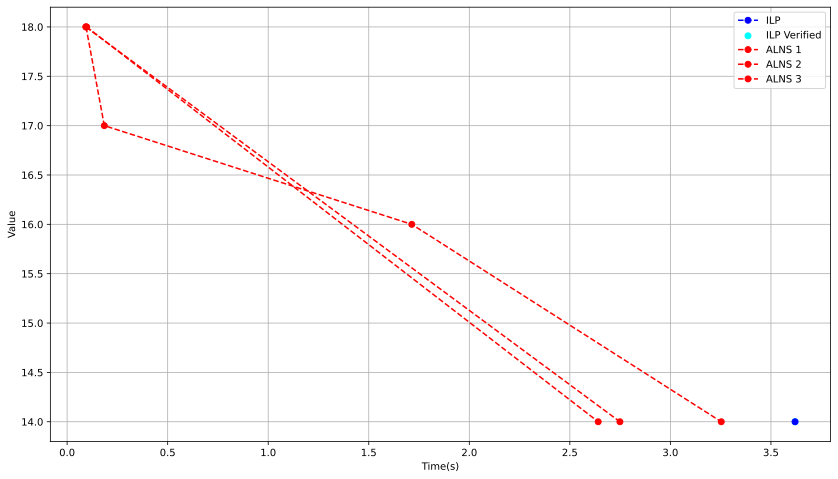

In [20]:
# Plot setup
plt.figure(figsize=(14, 8))
# Plot ILP pairs
ilp_times = [pair[1] for pair in ilp_pairs]
# ilp_times.append(float(data['ilp-solve-time'][0]))
ilp_values = [pair[0] for pair in ilp_pairs]
# ilp_values.append(float(data['ilp-min-fences'][0]))
plt.plot(ilp_times, ilp_values, color='blue', label='ILP', marker='o', linestyle='--')


# Add the last ILP point separately with a different color
last_ilp_time = float(data['ilp-solve-time'][30])
last_ilp_value = float(data['ilp-min-fences'][30])
plt.scatter([last_ilp_time], [last_ilp_value], color='cyan', label='ILP Verified', marker='o')

plt.plot([ilp_times[-1], last_ilp_time], [ilp_values[-1], last_ilp_value], color='cyan', linestyle='--')

# # Define colors for ALNS pairs
# alns_colors = ['red', 'green', 'purple', 'orange', 'brown']

# Plot each ALNS pair with different colors
for i, pairs in enumerate(alns_pairs):
    alns_times = [pair[1] for pair in pairs]
    alns_values = [pair[0] for pair in pairs]
    plt.plot(alns_times, alns_values, color='red', label=f'ALNS {i+1}', marker='o', linestyle='--')

# Final plot adjustments
plt.xlabel('Time(s)')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()